In [1]:
import numpy as np
import scipy
import jax.numpy as jnp
import jax

In [4]:
# Implement algorithm  for 1 dimension, and vmap over dimensions
h = 0.1
q = 1
sigma = 1.0

def get_A(q, h):
    js = jnp.arange(q + 1)
    ij = js - js[..., None]
    ij = ij  * (ij >= 0)

    num = h ** ij
    denom = jnp.round(jnp.exp(jax.scipy.special.gammaln(ij + 1)), 0)

    return jnp.triu(num / denom)


def get_Q(q, h, sigma=0.1):
    js = jnp.arange(q + 1)
    ipj = (2 * q + 1) - (js + js[...,None])
    qmj = jax.scipy.special.gammaln(q - js + 1)

    qmj = jnp.round(jnp.exp(qmj), 0)
    qfaci = qmj * qmj[...,None]

    num = h ** ipj
    denom = qfaci * ipj

    return sigma ** 2 * num / denom

In [5]:
F = np.array(
    [[0,1,0,0],
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,0]]
)

F = F * h

print(scipy.linalg.expm(F))

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [28]:
from functools import partial


def solve_kf(m0, P0, t0=0, t1=8, steps=50, R=0.0, q=2):

    m, P = m0, P0

    all_ms = [m0]
    
    h = (t1 - t0) / steps
    ts = jnp.linspace(float(t0), float(t1), steps + 1)

    print(f'Using t0={t0}, t1={t1} for {steps} steps')
    print(f'ts={ts}')
    print(f'Using h={h} for {steps} steps')

    A = get_A(q, h)
    Q = get_Q(q, h, sigma=1)
    
    @partial(jax.vmap, in_axes=(0, 0, None))
    def kalman_predict(m, P, t_i):
        m_minus = A @ m

        P_minus = A @ P @ A.T + Q
        return m_minus, P_minus
    
    @partial(jax.vmap, in_axes=(0, 0, 0, None))
    def kalman_step(z, m_minus, P_minus, t_i):
        v = z  - m_minus[1, :]

        S = P_minus[1, 1] + R

        K = P_minus[:, [1]] * (1.0 / S)
        
        m = m_minus + K @ v[None]

        P = P_minus - K @ S[None, None] @ K.T
        return m, P
    
    for t_i in ts[:-1]:
        
        # Predict
        m_minus, P_minus = kalman_predict(m, P, t_i)
        z = f(t_i, m_minus[:, 0, :].T).T # This odd transpose is because we assume
                                         # the vector fields second axis is dimension of the state space
    
        # Update
        m, P = kalman_step(z, m_minus, P_minus, t_i)
        all_ms.append(m_minus)

    return all_ms, ts

# Linear System

(2, 3, 1) (2, 3, 3)
0.5
(16, 2, 3, 1) (2, 3, 3)


(-147.997900390625, 2500.0)

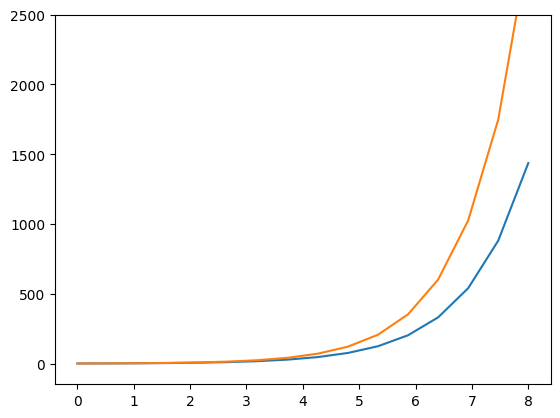

In [26]:
t1 = 8
h = 0.5
steps = int(t1 / h)

q = 2
m0 = jnp.array([1., 1.0])
P0 = jnp.array([
    [0, 0],
    [0, 1],
])


m0 = jnp.zeros(q+1).at[:2].set(m0)
P0 = jnp.eye(q+1).at[0,0].set(0.0)

# quick 2D test

m0 = jnp.array([m0, m0])[..., None]
P0 = jnp.array([P0, P0])


def f(t, x):
    scaling = jnp.array([1, 1.06])[None, ...]
    return x * scaling

print(m0.shape, P0.shape)
ms, ts = solve_kf(m0, P0, t1=t1, steps=steps, q=q)

import matplotlib.pyplot as plt

ms = jnp.array(ms)
print(ms.shape, P0.shape)
plt.plot(ts, ms[:, 0, 0])
plt.plot(ts, jnp.exp(ts))
plt.ylim(top=2500)
# plt.plot(ts, ms[:, 1, 0])
# plt.plot(ts, ms[:, 1, 0])

(2, 3, 1)
0.5
(24, 2, 3, 1)


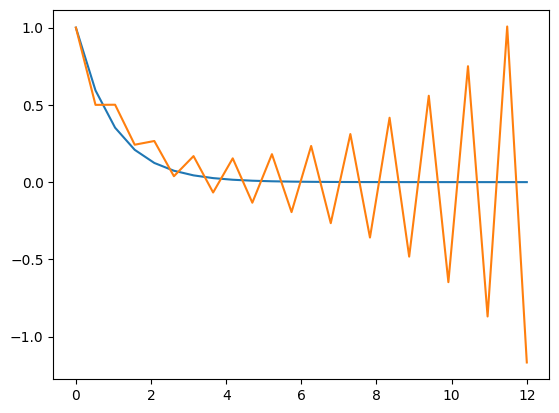

In [33]:
t1 = 12
h = 0.5
steps = int(t1 / h)


m0_neg = jnp.array([1., -1.0])
P0_neg = jnp.array([
    [0, 0],
    [0, 1],
])


q_neg = 2

m0_neg = jnp.zeros(q_neg+1).at[:2].set(m0_neg)
P0_neg = jnp.eye(q_neg+1).at[0,0].set(0.0)

# quick 2D test

m0_neg = jnp.array([m0_neg, m0_neg])[...,None]
P0_neg = jnp.array([P0_neg, P0_neg])


def f(t, x):
    scaling = jnp.array([-1, -1])[None, ...]
    return x * scaling

print(m0_neg.shape)
ms, ts = solve_kf(m0_neg, P0_neg, t1=t1, steps=steps, q=q_neg)

import matplotlib.pyplot as plt

ms = jnp.array(ms)
print(ms.shape)

plt.plot(ts, jnp.exp(-ts))
plt.plot(ts, ms[:, 0, 0])
# plt.ylim(top=2500)
# plt.plot(ts, ms[:, 1, 0])
# plt.plot(ts, ms[:, 1, 0])

# Oscilatory System in 4 dimensions

In [28]:
import math

eps = 0.1

x0 = jnp.array(
    [1.0 - eps, 0.0, 0.0, math.sqrt((1.0 + eps) / (1.0 - eps))]
)

def f(t, x):
    
    x0, x1, x2, x3 = x[:,[0]], x[:,[1]], x[:,[2]], x[:,[3]]
    d0 = x2
    d1 = x3
    d2 = -x0 / (x0**2 + x1**2)**(3.0/2.0)
    d3 = -x1 / (x0**2 + x1**2)**(3.0/2.0)
    
    d = np.concatenate(
        [d0, d1, d2, d3],
        axis=1
    )
    return d

In [29]:
m0.shape, P0.shape

((2, 3, 1), (2, 3, 3))

In [30]:
d0 = f(0, x0[None,...])

m0_ = jnp.concatenate([x0[None,...], d0, x0[None,...] * 0]).swapaxes(0,1) [..., None]

P0_base = jnp.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])


P0_ = jnp.array([P0_base, P0_base, P0_base , P0_base])

0.1


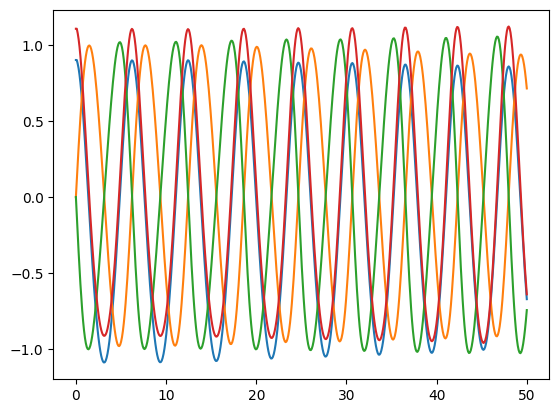

In [31]:


t1_ = 50
h_ = 0.1
steps_ = int(t1_/ h_)

ms_, ts_ = solve_kf(m0_, P0_, t1=t1_, steps=steps_)

import matplotlib.pyplot as plt

ms_ = jnp.array(ms_)

plt.plot(ts_, ms_[:, 0, 0])
plt.plot(ts_, ms_[:, 1, 0])
plt.plot(ts_, ms_[:, 2, 0])
plt.plot(ts_, ms_[:, 3, 0])
